In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from numba import jit
from timeit import default_timer as timer
from dask import array as da
import dask
from dask.distributed import Client
import multiprocessing as mp

## Naive Implementation

In [ ]:
def compute_mandelbrot(c, max_iters, threshold):
    z = 0
    for n in range(max_iters):
        if abs(z) > threshold:
            return n
        else:
            z = z**2 + c
    return  max_iters # return max_iters if the point doesn't diverge after max_iters iterations

def mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold):
    re = np.linspace(re_min, re_max, p_re)
    im = np.linspace(im_min, im_max, p_im)
    
    mset = np.zeros((p_im, p_re)) # create an array to store the mandelbrot set
    
    for i in range(p_im): # rows (y-axis)
        for j in range(p_re): # columns (x-axis)
            c = re[j] +1j * im[i] # create a starting point
            mset[i, j] = compute_mandelbrot(c, max_iters, threshold) # store the number of iterations before diverge
    return mset

In [ ]:
p_re = 5000 # number of points in the real part
p_im = 5000 # number of points in the imaginary part
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2
# outputdir = "miniproject/output"
# os.makedirs(outputdir, exist_ok=True)

print("Computing Mandelbrot set...")
start_time = timer()
mset = mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold)
end_time = timer()
print(f"Execution time: {end_time - start_time}s")

plt.imshow(mset, extent=[re_min, re_max, im_min, im_max])
plt.set_cmap('hot')
plt.colorbar()
plt.show()
# plt.imsave(os.path.join(outputdir, f"{os.path.basename(__file__).split(".")[0]}_{max_iters}_iters.pdf"), mset)

## Using Multiprocessing

This implementation uses the multiprocessing library. The chunking is row-based, meaning it makes a list of the amount of rows in the mandelbrot set, and chunks the list according to the given chunk size. This was chosen over a pixel wise chunking, to avoid looping through the entire image to assign pixels to the cores.

Observations show that larger batch size actually runs slower, no matter the amount of processors. This makes sense from a work balancing point of view, as the mandelbrot set is very not balanced in terms of computation required relative to the row being worked on.

One possible optimization could be to shuffle the row indicies before chunking them. This could lead to better work balancing

In [2]:
def compute_mandelbrot(c, max_iters, threshold):
    z = 0
    for n in range(max_iters):
        if abs(z) > threshold:
            return n
        else:
            z = z**2 + c
    return  max_iters # return max_iters if the point doesn't diverge after max_iters iterations

def process_chunk(args):
    # unpack args
    chunk, re, im, max_iters, threshold = args
    results = np.zeros((len(chunk), len(re))) # stores n amount of rows
    
    for idx, i in enumerate(chunk):
        for j in range(len(re)):
            c = re[j] +1j * im[i] # create a starting point
            results[idx, j] = compute_mandelbrot(c, max_iters, threshold)
    return (chunk, results) # return indicies that current chunk has processed

def mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, num_processors, chunk_size):
    re = np.linspace(re_min, re_max, p_re)
    im = np.linspace(im_min, im_max, p_im)
    mset = np.zeros((p_im, p_re)) # create an array to store the mandelbrot set
    
    # chunk each row (imaginary part) by chunk size
    row_idx = list(range(p_im))
    chunks = [row_idx[i:i+chunk_size] for i in range(0, p_im, chunk_size)]
    
    # pass arguments to processing function
    # TODO this could be optimized in a class implementation
    #       rather than passing arguments everytime
    args = [(chunk, re, im, max_iters, threshold) for chunk in chunks]
    
    # spawn processes
    with mp.Pool(processes=num_processors) as pool:
        results = pool.map(process_chunk, args)
    
    # merge chunked results
    for chunk_indicies, chunk_result in results:
        for idx, i in enumerate(chunk_indicies):
            mset[i,:] = chunk_result[idx, :]
    
    return mset

In [3]:
p_re = 5000 # number of points in the real part
p_im = 5000 # number of points in the imaginary part
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2
num_processors = [4, 8, 12, 16]
chunk_size = [50, 100, 250, 500, 1000, 2500]

runtimes = {} # dict to store runtimes

for num_p in num_processors:
    for size in chunk_size:
        start_time = timer()
        mset = mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, num_p, size)
        runtimes[(num_p, size)] = timer() - start_time
        print(f"Processors: {num_p}, chunk size: {size}, Runtime: {timer() - start_time:.4f}s")

Processors: 4, chunk size: 50, Runtime: 34.7585s
Processors: 4, chunk size: 100, Runtime: 36.4600s
Processors: 4, chunk size: 250, Runtime: 37.1760s
Processors: 4, chunk size: 500, Runtime: 44.2985s
Processors: 4, chunk size: 1000, Runtime: 52.8835s
Processors: 4, chunk size: 2500, Runtime: 62.6809s
Processors: 8, chunk size: 50, Runtime: 25.1203s
Processors: 8, chunk size: 100, Runtime: 25.1963s
Processors: 8, chunk size: 250, Runtime: 24.3029s
Processors: 8, chunk size: 500, Runtime: 32.3525s
Processors: 8, chunk size: 1000, Runtime: 52.2196s
Processors: 8, chunk size: 2500, Runtime: 64.6709s
Processors: 12, chunk size: 50, Runtime: 20.7127s
Processors: 12, chunk size: 100, Runtime: 22.5067s
Processors: 12, chunk size: 250, Runtime: 22.2912s
Processors: 12, chunk size: 500, Runtime: 31.6294s
Processors: 12, chunk size: 1000, Runtime: 50.5822s
Processors: 12, chunk size: 2500, Runtime: 61.6609s
Processors: 16, chunk size: 50, Runtime: 20.3886s
Processors: 16, chunk size: 100, Runtime:

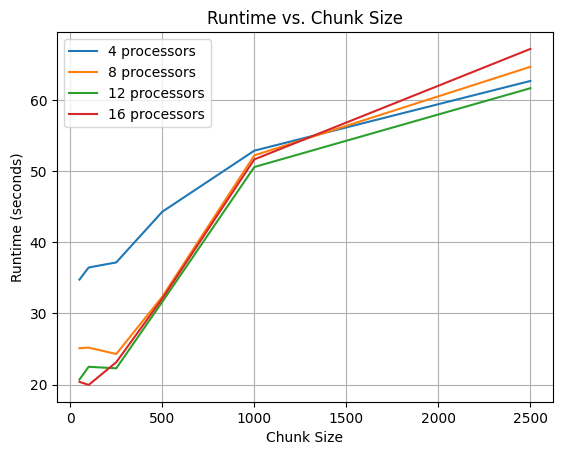

In [4]:
plt.figure()
for num_p in num_processors:
    results = [runtimes[(num_p, size)] for size in chunk_size]
    plt.plot(chunk_size, results, label=f"{num_p} processors")

plt.xlabel('Chunk Size')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs. Chunk Size')
plt.legend()
plt.grid(True)
# plt.xscale('log')
plt.show()

## Numpy Implementation

In [4]:
def vector_compute_mandelbrot(C, max_iters, threshold):
    z = np.zeros(C.shape, dtype=complex)
    mset = np.zeros(C.shape, dtype=np.uint16) # array to store number of iterations before divergence
    
    for _ in tqdm(range(max_iters), desc="Computing Mandelbrot set"):
        mask = np.abs(z) <= threshold
        z[mask] = z[mask]**2 + C[mask] # perform operation on points that have not diverged
        mset += mask # add +1 to all points with true in the mask
    return mset

def vector_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold):
    re = np.linspace(re_min, re_max, p_re)
    im = np.linspace(im_min, im_max, p_im)
    C = re[np.newaxis, :] + 1j * im[:, np.newaxis] # create axis across columns for real part and rows for imaginary part
    
    mset = vector_compute_mandelbrot(C, max_iters, threshold)
    return mset

Computing Mandelbrot set: 100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


Execution time: 17.332885540999996s


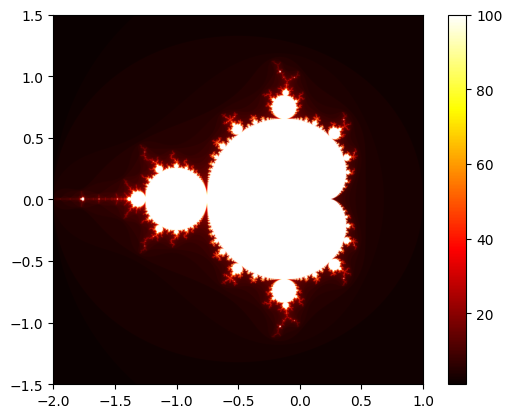

In [5]:
p_re = 5000
p_im = 5000
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2
# outputdir = "miniproject/output"
# os.makedirs(outputdir, exist_ok=True)

start_time = timer()
mset = vector_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold)
end_time = timer()
print(f"Execution time: {end_time - start_time}s")


plt.imshow(mset, extent=[re_min, re_max, im_min, im_max])
plt.set_cmap('hot')
plt.colorbar()
plt.show()
# plt.imsave(os.path.join(outputdir, f"{os.path.basename(__file__).split(".")[0]}_{max_iters}_iters.pdf"), mset)

## Dask Implementation - Local

Chunk size calculation for 4MB L2 cache

Each calculation involves 2 complex64 and 1 uint8 value, meaning 136 bits or 17 bytes.

$17B * \mathrm{chunk\ size} = 4e6B$

To account for a rectangular chunk:

$17B * \mathrm{chunk\ size}^2 = 4e6B/8$ => $\mathrm{chunk\ size} = \sqrt{\frac{5e5B}{17B}} = 171$

In [2]:
def dask_compute_mandelbrot(C, max_iters, threshold):
    z = np.zeros(C.shape, dtype=np.complex64) # populate z with starting points
    mset = np.zeros(C.shape, dtype=np.uint8) # NOTE uint16 may be too small for large max_iters
    
    for _ in range(max_iters):
        # iterate points which didn't diverge, where mask is true
        mask = np.abs(z) <= threshold
        z[mask] = z[mask]**2 + C[mask]
        mset[mask] += 1
    return mset

def dask_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, chunk_size):
    # chunk size can differ for real and imaginary part
    re = da.linspace(re_min, re_max, p_re, chunk_size)
    im = da.linspace(im_min, im_max, p_im, chunk_size)

    # create complex plane
    x, y = da.meshgrid(re, im, indexing="xy")
    C = x + 1j * y
    
    # using map_blocks to fix memory issues
    mset = da.map_blocks(dask_compute_mandelbrot, C, max_iters, threshold, dtype=np.uint16)
    
    return mset

In [3]:
p_re = 5000
p_im = 5000
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2
chunk_size = [50, 85, 100, 250, 500, 1000, 2500]

results = {}

client = Client(n_workers=16, memory_limit="10GB") # start local cluster
print("Computing Mandelbrot...")
for size in chunk_size:
    start_time = timer()
    mset = dask_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, chunk_size)
    mset = mset.compute()
    runtime = timer() - start_time
    results[size] = runtime
    print(f"Chunk size: {size}, Runtime: {runtime}")

client.cluster.close()
client.close()

Computing Mandelbrot...
Chunk size: 50, Runtime: 14.27881633600009
Chunk size: 85, Runtime: 13.304934040000262
Chunk size: 100, Runtime: 13.049916365999707
Chunk size: 250, Runtime: 13.057220427000175
Chunk size: 500, Runtime: 13.027538240000467
Chunk size: 1000, Runtime: 12.77308088800055
Chunk size: 2500, Runtime: 12.936880975999884


### Dask Comparison with Numpy

The local dask implementation seems to run on par, or slightly slower than the numpy vector version. This would likely change if the resolution of the mandelbrot set was increased, or with better management of dask due to overhead.

|       | Runtime (s) |
|-------|-------------|
| Numpy | ~18     |
| Dask  | ~13      |

## Dask - Distributed
Chunk size: 50, Runtime: 19.08118848399954

Chunk size: 85, Runtime: 12.911830838000242

Chunk size: 100, Runtime: 12.908700513999975

Chunk size: 250, Runtime: 19.09751945500011

Chunk size: 500, Runtime: 12.943626025999947

Chunk size: 1000, Runtime: 12.861898168999687

Chunk size: 2500, Runtime: 18.997311197000272

In [ ]:
def dask_compute_mandelbrot(C, max_iters, threshold):
    z = np.zeros(C.shape, dtype=np.complex64) # populate z with starting points
    mset = np.zeros(C.shape, dtype=np.uint8) # NOTE uint16 may be too small for large max_iters
    
    for _ in range(max_iters):
        # iterate points which didn't diverge, where mask is true
        mask = np.abs(z) <= threshold
        z[mask] = z[mask]**2 + C[mask]
        mset[mask] += 1
    return mset

def dask_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, chunk_size):
    # chunk size can differ for real and imaginary part
    re = da.linspace(re_min, re_max, p_re, chunk_size)
    im = da.linspace(im_min, im_max, p_im, chunk_size)

    # create complex plane
    x, y = da.meshgrid(re, im, indexing="xy")
    C = x + 1j * y
    
    # using map_blocks to fix memory issues
    mset = da.map_blocks(dask_compute_mandelbrot, C, max_iters, threshold, dtype=np.uint16)
    
    return mset

if __name__ == "__main__":
    p_re = 5000
    p_im = 5000
    re_min, re_max = -2.0, 1.0
    im_min, im_max = -1.5, 1.5
    max_iters = 100
    threshold = 2
    chunk_size = [50, 85, 100, 250, 500, 1000, 2500]

    results = {}

    client = Client(address="10.92.1.39:8786") # start local cluster
    print("Computing Mandelbrot...")
    for size in chunk_size:
        start_time = timer()
        mset = dask_mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, chunk_size)
        mset = mset.compute()
        runtime = timer() - start_time
        results[size] = runtime
        print(f"Chunk size: {size}, Runtime: {runtime}")

    client.close()

### Distributed Summary
The execution was distributed across 3 worker nodes, each with 4 cpus available on strato. The execution is somehow slower than a local cluster. A possible explanation could be that this was done from outside AAU campus, through a VPN so maybe there could be some network bottlenecks happening.

It also seems like I was running single core on the strato, so effectively I was using fewer cores in the distributed system than what I was using on the local cluster.

It could also just be that I'm doing this wrong :)

| Chunk size | Local (s) | Distributed (s)|
|------------|-------|-------------|
| 50         | 14.3  | 19.1        |
| 85         | 13.3  | 12.9        |
| 100        | 13.1  | 12.9        |
| 250        | 13.0  | 19.1        |
| 500        | 13.0  | 12.9        |
| 1000       | 12.8  | 12.8        |
| 2500       | 12.9  | 19.0        |

## Further Optimization
This section will include a few small and easy optimizations

### Multiprocessing with JIT
This implementation is a lot faster than all other implementations explored. Also the original JIT implementation from part 1

In [5]:
@jit(nopython=True)
def compute_mandelbrot(c, max_iters, threshold):
    z = 0
    for n in range(max_iters):
        if abs(z) > threshold:
            return n
        else:
            z = z**2 + c
    return  max_iters # return max_iters if the point doesn't diverge after max_iters iterations

@jit(nopython=True)
def process_chunk(args):
    # unpack args
    chunk, re, im, max_iters, threshold = args
    results = np.zeros((len(chunk), len(re))) # stores n amount of rows
    
    for idx, i in enumerate(chunk):
        for j in range(len(re)):
            c = re[j] +1j * im[i] # create a starting point
            results[idx, j] = compute_mandelbrot(c, max_iters, threshold)
    return (chunk, results) # return indicies that current chunk has processed

def mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, num_processors, chunk_size):
    re = np.linspace(re_min, re_max, p_re)
    im = np.linspace(im_min, im_max, p_im)
    mset = np.zeros((p_im, p_re)) # create an array to store the mandelbrot set
    
    # chunk each row (imaginary part) by chunk size
    row_idx = list(range(p_im))
    chunks = [row_idx[i:i+chunk_size] for i in range(0, p_im, chunk_size)]
    
    # pass arguments to processing function
    args = [(chunk, re, im, max_iters, threshold) for chunk in chunks]
    
    # spawn processes
    with mp.Pool(processes=num_processors) as pool:
        results = pool.map(process_chunk, args)
    
    # merge chunked results
    for chunk_indicies, chunk_result in results:
        for idx, i in enumerate(chunk_indicies):
            mset[i,:] = chunk_result[idx, :]
    
    return mset

Processors: 4, chunk size: 50, Runtime: 2.0274s
Processors: 4, chunk size: 100, Runtime: 1.9675s
Processors: 4, chunk size: 250, Runtime: 2.1473s
Processors: 4, chunk size: 500, Runtime: 2.0242s
Processors: 4, chunk size: 1000, Runtime: 2.4496s
Processors: 4, chunk size: 2500, Runtime: 3.1372s
Processors: 8, chunk size: 50, Runtime: 1.8963s
Processors: 8, chunk size: 100, Runtime: 1.9082s
Processors: 8, chunk size: 250, Runtime: 1.9432s
Processors: 8, chunk size: 500, Runtime: 1.9723s
Processors: 8, chunk size: 1000, Runtime: 2.0202s
Processors: 8, chunk size: 2500, Runtime: 3.1223s
Processors: 12, chunk size: 50, Runtime: 2.0401s
Processors: 12, chunk size: 100, Runtime: 2.2351s
Processors: 12, chunk size: 250, Runtime: 2.2271s
Processors: 12, chunk size: 500, Runtime: 2.1667s
Processors: 12, chunk size: 1000, Runtime: 2.1149s
Processors: 12, chunk size: 2500, Runtime: 3.1929s
Processors: 16, chunk size: 50, Runtime: 2.6349s
Processors: 16, chunk size: 100, Runtime: 2.3096s
Processors

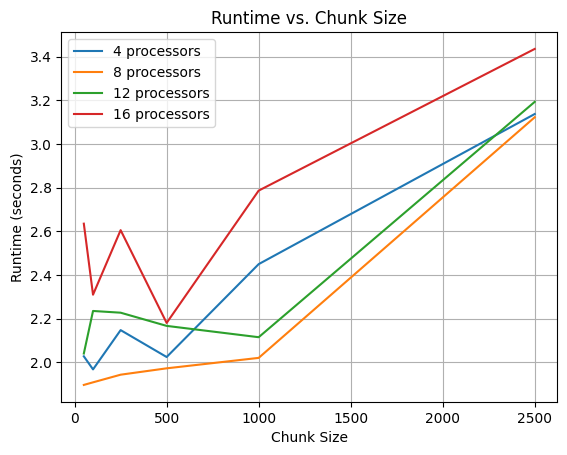

In [10]:
p_re = 5000 # number of points in the real part
p_im = 5000 # number of points in the imaginary part
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2
num_processors = [4, 8, 12, 16]
chunk_size = [50, 100, 250, 500, 1000, 2500]

jit_runtimes = {} # dict to store runtimes

for num_p in num_processors:
    for size in chunk_size:
        start_time = timer()
        mset = mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, num_p, size)
        jit_runtimes[(num_p, size)] = timer() - start_time
        print(f"Processors: {num_p}, chunk size: {size}, Runtime: {timer() - start_time:.4f}s")
        
plt.figure()
for num_p in num_processors:
    results = [jit_runtimes[(num_p, size)] for size in chunk_size]
    plt.plot(chunk_size, results, label=f"{num_p} processors")

plt.xlabel('Chunk Size')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs. Chunk Size')
plt.legend()
plt.grid(True)
# plt.xscale('log')
plt.show()

### Shuffled chunking
This approach addresses the work load balancing issue in the original multiprocessing. This will be done by just randomly shuffling the rows so that a single core will likely not be working on several heavy rows.

This approach proved to not really change much. Probably because chunking in entire rows is a too big and should be blocks instead.

In [11]:
import random

@jit(nopython=True)
def compute_mandelbrot(c, max_iters, threshold):
    z = 0
    for n in range(max_iters):
        if abs(z) > threshold:
            return n
        else:
            z = z**2 + c
    return  max_iters # return max_iters if the point doesn't diverge after max_iters iterations

@jit(nopython=True)
def process_chunk(args):
    # unpack args
    chunk, re, im, max_iters, threshold = args
    results = np.zeros((len(chunk), len(re))) # stores n amount of rows
    
    for idx, i in enumerate(chunk):
        for j in range(len(re)):
            c = re[j] +1j * im[i] # create a starting point
            results[idx, j] = compute_mandelbrot(c, max_iters, threshold)
    return (chunk, results) # return indicies that current chunk has processed

def mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, num_processors, chunk_size):
    re = np.linspace(re_min, re_max, p_re)
    im = np.linspace(im_min, im_max, p_im)
    mset = np.zeros((p_im, p_re)) # create an array to store the mandelbrot set
    
    # chunk each row (imaginary part) by chunk size
    row_idx = list(range(p_im))
    random.shuffle(row_idx)
    chunks = [row_idx[i:i+chunk_size] for i in range(0, p_im, chunk_size)]
    
    # pass arguments to processing function
    args = [(chunk, re, im, max_iters, threshold) for chunk in chunks]
    
    # spawn processes
    with mp.Pool(processes=num_processors) as pool:
        results = pool.map(process_chunk, args)
    
    # merge chunked results
    for chunk_indicies, chunk_result in results:
        for idx, i in enumerate(chunk_indicies):
            mset[i,:] = chunk_result[idx, :]
    
    return mset

Processors: 4, chunk size: 50, Runtime: 2.1001s
Processors: 4, chunk size: 100, Runtime: 2.2051s
Processors: 4, chunk size: 250, Runtime: 2.2437s
Processors: 4, chunk size: 500, Runtime: 2.4122s
Processors: 4, chunk size: 1000, Runtime: 2.6054s
Processors: 4, chunk size: 2500, Runtime: 3.2950s
Processors: 8, chunk size: 50, Runtime: 1.8455s
Processors: 8, chunk size: 100, Runtime: 1.7722s
Processors: 8, chunk size: 250, Runtime: 1.7426s
Processors: 8, chunk size: 500, Runtime: 1.8390s
Processors: 8, chunk size: 1000, Runtime: 2.0536s
Processors: 8, chunk size: 2500, Runtime: 3.0848s
Processors: 12, chunk size: 50, Runtime: 2.1140s
Processors: 12, chunk size: 100, Runtime: 2.2011s
Processors: 12, chunk size: 250, Runtime: 2.1684s
Processors: 12, chunk size: 500, Runtime: 2.2508s
Processors: 12, chunk size: 1000, Runtime: 2.1498s
Processors: 12, chunk size: 2500, Runtime: 3.1093s
Processors: 16, chunk size: 50, Runtime: 2.3212s
Processors: 16, chunk size: 100, Runtime: 2.4677s
Processors

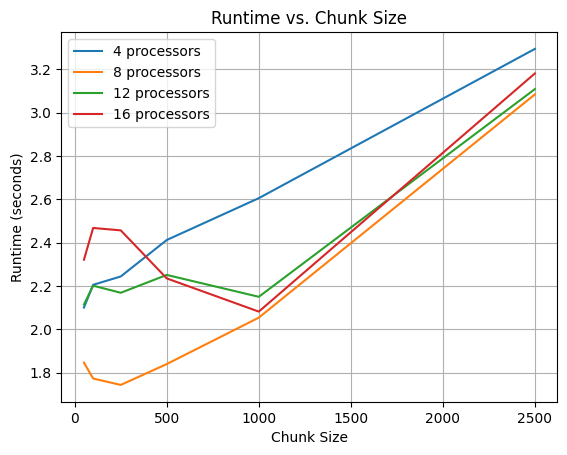

In [12]:
p_re = 5000 # number of points in the real part
p_im = 5000 # number of points in the imaginary part
re_min, re_max = -2.0, 1.0
im_min, im_max = -1.5, 1.5
max_iters = 100
threshold = 2
num_processors = [4, 8, 12, 16]
chunk_size = [50, 100, 250, 500, 1000, 2500]

random_runtimes = {} # dict to store runtimes

for num_p in num_processors:
    for size in chunk_size:
        start_time = timer()
        mset = mandelbrot_set(re_min, re_max, im_min, im_max, p_re, p_im, max_iters, threshold, num_p, size)
        random_runtimes[(num_p, size)] = timer() - start_time
        print(f"Processors: {num_p}, chunk size: {size}, Runtime: {timer() - start_time:.4f}s")
        
plt.figure()
for num_p in num_processors:
    results = [random_runtimes[(num_p, size)] for size in chunk_size]
    plt.plot(chunk_size, results, label=f"{num_p} processors")

plt.xlabel('Chunk Size')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs. Chunk Size')
plt.legend()
plt.grid(True)
# plt.xscale('log')
plt.show()